In [1]:
import clip
import torch

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [27]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'ViT-B/32']

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

# Load the photo IDs
photo_ids = pd.read_csv("numpy/features/photo_ids.csv")
photo_ids = list(photo_ids['photo_id'])

# Load the features vectors
photo_features = np.load("numpy/features/features.npy")

# Convert features to Tensors: Float32 on CPU and Float16 on GPU
if device == "cpu":
  photo_features = torch.from_numpy(photo_features).float().to(device)
else:
  photo_features = torch.from_numpy(photo_features).to(device)

# Print some statistics
print(f"Photos loaded: {len(photo_ids)}")
print('Device is',device)

Photos loaded: 321693
Device is cuda


In [3]:
def encode_search_query(search_query):
  with torch.no_grad():
    # Encode and normalize the search query using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the feature vector
  return text_encoded

In [4]:
def find_best_matches(text_features, photo_features, photo_ids, results_count=3):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)

  # Sort the photos by their similarity score
  best_photo_idx = (-similarities).argsort()

  # Return the photo IDs of the best matches
  return [photo_ids[i] for i in best_photo_idx[:results_count]]

In [5]:
photos_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk('imgs') for f in filenames if os.path.splitext(f)[1] == '.jpg']

In [6]:
photos_files[0]

'imgs/id_1740851/id_1740851_9151768960207312_img.jpg'

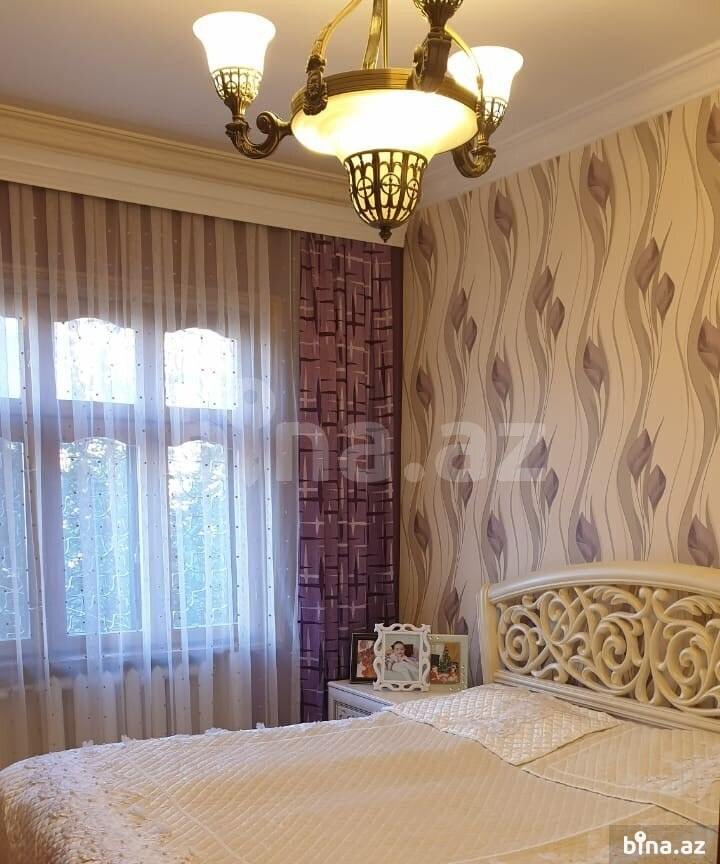

In [7]:

from IPython.display import Image 
cleaned = re.findall('id_\\d+',photo_ids[0])
concat = f"imgs/{cleaned[0]}"
pil_img = Image(filename=f"{concat}/{photo_ids[0]}.jpg")
display(pil_img)

In [8]:
from PIL import Image
from IPython.core.display import HTML

def display_photo(photo_id):
  #cleaned = re.findall('id_\\d+',photo_ids[0])
  cleaned = re.findall('id_\\d+',photo_id)
  concat = f"imgs/{cleaned[0]}"
  im = Image.open(f"{concat}/{photo_id}.jpg")
  display(im.resize((round(im.size[0]*0.3), round(im.size[1]*0.3))))
  print()

In [9]:
def search_unslash(search_query, photo_features, photo_ids, results_count=3):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  best_photo_ids = find_best_matches(text_features, photo_features, photo_ids, results_count)
  print(best_photo_ids)

  # Display the best photos
  for photo_id in best_photo_ids:
    display_photo(photo_id)


['id_1711576_325832449528594840_img', 'id_1922688_807471719546756098_img', 'id_1922688_437427457516524787_img']


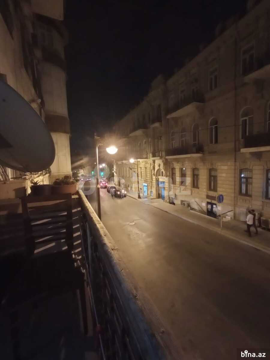

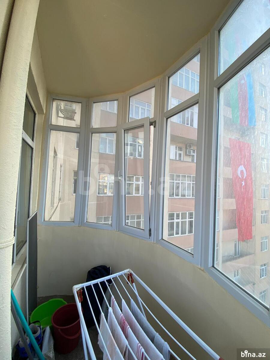

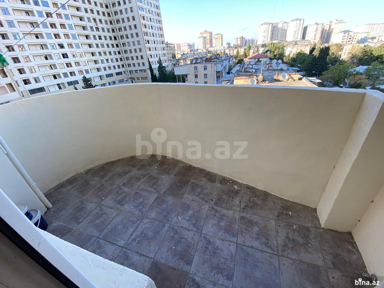

In [32]:
search_query = "wide balcony with great view"

search_unslash(search_query, photo_features, photo_ids, 3)